# Forest Fire Burn Area Prediction
Written by: Marshall Mykietyshyn

Data hosted on [UCI Machine Learning Repository](http://archive.ics.uci.edu/ml/datasets/Forest+Fires).

The purpose of this notebook is to predict the forest fire burn area. This is a popular regression dataset found on both Kaggle and the UCI Machine Learning Repository. The two data sets are identical, but the one used here was downloaded from UCI. The forest fire weather index (FWI) system features FFMC, DMC, DC and ISI are described [here](https://cwfis.cfs.nrcan.gc.ca/background/summary/fwi). The target variable is burn area, which can be predicted by a set of feature variables listed below. The data to be used is already pre-processed by checking for missing values, outliers and converting the categorical features numerical values. However, there are unbalanced features that must be addressed, the target has nearly a 50% proportion of zeros, and the features are generally not Gaussian distributed. 

1. X - x-axis spatial coordinate within the Montesinho park map: 1 to 9
2. Y - y-axis spatial coordinate within the Montesinho park map: 2 to 9
3. month - month of the year: 0 to 11
4. day - day of the week: 0 to 6
5. FFMC - FFMC index from the FWI system: 18.7 to 96.20
6. DMC - DMC index from the FWI system: 1.1 to 291.3
7. DC - DC index from the FWI system: 7.9 to 860.6
8. ISI - ISI index from the FWI system: 0.0 to 56.10
9. temp - temperature in Celsius degrees: 2.2 to 33.30
10. RH - relative humidity in %: 15.0 to 100
11. wind - wind speed in km/h: 0.40 to 9.40
12. rain - outside rain in mm/m2 : 0.0 to 6.4
13. area - the burned area of the forest (in ha): 0.00 to 1090.84

Notes:
- First, try predicting burn area directly
    - Resample to account for feature imbalances
    - Eliminate day category as it is likely just noise
    - Maybe eliminate rain due to high number of zeros
- Second, split the problem into classification (predict whether a fire occurs) and regression (if there is a fire, predict the burn area)
    - Can represent the results as a joint probability see [here](https://datascience.stackexchange.com/questions/25576/best-method-to-deal-with-too-many-zeroes-in-regression-problem)
    - Reference for two part model: "[Analyzing Skewed Continuous Outcomes With Many Zeros: A Tutorial for Social Work and Youth Prevention Science Researchers](https://doi.org/10.1086/701235)"
- Look at the effects of whitening to improve model performance
- Maximize predictive capabilities of model
    - Do some research to determine which model is best suited to the task
    
    
Process
- Split into train and test sets before balancing data, to avoid 
- Upsample minority data to match frequency of August and September
    - Danger with this is some months only have a single data point, so it's over fitting the fuck outta those points
- Upsample a little bit and then split the data into multiple sets
- Don't upsample at all and then 

In [27]:
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
from sklearn.utils import resample
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV, ShuffleSplit
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score


In [17]:
def weighted_upsample(data, feature, n_samples=500, seed=123456, plot=True):
    """ Upsamples the data, weighted by the distribution of a given feature.
    
    This function attempts to balance the given dataset by upsampling based on
    an inverse relationship to the current distribution of a particular feature.
    Data points associated with frequently occuring insatances of a feature are
    less likely to be sampled, and vice versa. For example, if there are two
    categories, with one occuring 4 times and the other occurring once, the
    minority feature will be four times as likel to be sampled. The weights
    are recalculated after each sample is added to the dataset.
    
    This function currently only works with discretized or categorical features.
    There is no stopping condition, and the number of samples must be chosen.
    Therefore, if an insufficient number is chosen, the data set will not become
    balanced.
    
    Parameters
        data: DataFrame = the dataset to be upsampled (and/or balanced)
        feature: str = the feature whose distribution determines the weighting
        n_samples: int = the number of samples to add to the dataset
        seed: int = the random seed used to make the process repeatable
        plot: bool = True -> plots a histogram of the feature distribution
        
    Returns
        resampled_data: DataFrame = the upsampled/balanced dataset
    """
    
    counts = len(data[feature].value_counts())
    month_wts = np.zeros(counts)
    upsampled_data = data.copy()
    np.random.seed(seed)
    for i in range(n_samples):
        # Weight the sampling by the current distribution
        counts = upsampled_data[feature].value_counts()
        ind_sort = list(counts.index.values.astype(int))
        month_wts[ind_sort] = (1 / counts.values) / (1 / counts.values).sum()

        # Select a month to sample from and resample from that selection
        month_id = np.random.choice(12, p=month_wts)
        month_data = upsampled_data.loc[upsampled_data[feature] == month_id]
        new_sample = resample(month_data, n_samples=1)

        # Append the new sample to the existing data
        upsampled_data = pd.concat([upsampled_data, new_sample], ignore_index=True)

    if plot:
        sb.countplot(x=upsampled_data[feature])
        
    return upsampled_data


def resample_ensemble(major_class, minor_class, n_folds=5, seed=123456):
    """ Splits unbalanced data into subsets (folds).
    
    In each fold, the minority class is fully represented, while the majority
    class (the one with high frequency feature occurrences) is split into folds.
    This is an ensemble because the model can then be trained on each individual
    subset, and the final answer can be the average of the differently trained
    models.
    
    Parameters
        major_class: nd.array (observations, features) = the data corresponding
            to the high frequency class(es)
        minor_class: nd.array (observations, features) = the data corresponding
            to the low frequency class(es)
        n_folds:int = the number of subsets to split the majority class into
        seed: int = the random seed used to make the process repeatable
        
    Returns
        folds: list(tuples) = the X and y data for each resampled subset
    """
    
    np.random.seed(seed)
    np.random.shuffle(major_class)
    fold_sz = len(major_class) // n_folds
    folds = []
    for k in range(n_folds):
        major_fold = major_class[k * fold_sz:(k + 1) * fold_sz, :]
        comb_data = np.vstack((minor_class, major_fold))
        this_fold = comb_data[:, :-1], comb_data[:, -1]
        folds.append(this_fold)
    
        # sb.countplot(x=this_fold[0][:, 2], color=f'C{k}')
        # plt.show()
        
    return folds


In [3]:
# Load the pre-processed data
data = pd.read_csv('data/forestfires_preprocessed.csv')

# Eliminate the day and rain categories
data.drop(columns=['day', 'rain'], inplace=True)


In [4]:
# Split out the test set
data_nd = data.values
X_nd, y_nd = data_nd[:, :-1], data_nd[:, -1]
X_train, X_test, y_train, y_test = train_test_split(X_nd, y_nd, test_size=0.2, random_state=66, shuffle=True)
data_train = pd.DataFrame(np.hstack((X_train, y_train[:, None])))
data_train.columns = data.columns
# data_test = pd.DataFrame(np.hstack((X_test, y_test[:, None])))
# data_test.columns = data.columns


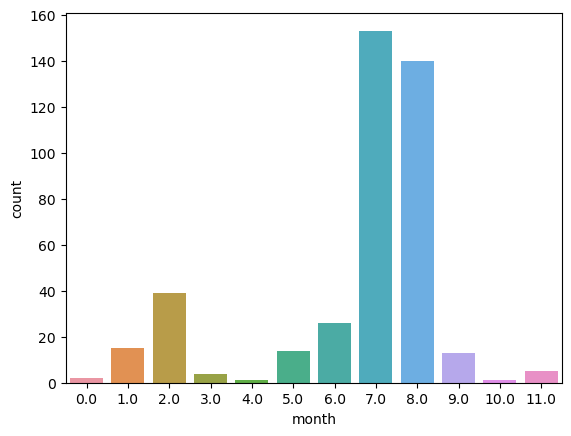

In [5]:
# Look at the distribution of months in the training data
sb.countplot(x=data_train.month);
# sb.countplot(x=data_test.month);


In [24]:
# Balance the dataset by resampling, weighted by frequency
resamp_train1 = weighted_upsample(data_train, 'month', n_samples=2000, plot=False)
resamp_train1_nd = resamp_train1.values
X_train_re1, y_train_re1 = resamp_train1_nd[:, :-1], resamp_train1_nd[:, -1]

# Balance the dataset by splitting the high frequency data into a training ensemble
#  Idea from here: https://www.kaggle.com/questions-and-answers/201922
major2 = data_train.loc[(data_train.month == 7) | (data_train.month == 8)].values
minor2 = data_train.loc[(data_train.month != 7) & (data_train.month != 8)].values
resamp_train2 = resample_ensemble(major2, minor2, n_folds=5)

# Balance the dataset by first upsampling, and then splitting into a resampled ensemble
resamp_train3 = weighted_upsample(data_train, 'month', n_samples=300, plot=False)
major3 = resamp_train3.loc[(resamp_train3.month == 7) | (resamp_train3.month == 8)].values
minor3 = resamp_train3.loc[(resamp_train3.month != 7) & (resamp_train3.month != 8)].values
resamp_train3 = resample_ensemble(major3, minor3, n_folds=3)
# for Xt, yt in resamp_train3:
#     sb.countplot(x=Xt[:, 2])
#     plt.show()

all_resamp_data = [[(X_train_re1, y_train_re1)], resamp_train2, resamp_train3]


In [7]:
# # Balance the data set by splitting the high frequency data into separate training sets
# #  Idea from here: https://www.kaggle.com/questions-and-answers/201922
# month_minority = data_train.loc[(data_train.month != 7) & (data_train.month != 8)].values
# # display(len(month_minority) / 10)
# month_majority = data_train.loc[(data_train.month == 7) | (data_train.month == 8)].values
# resamp_train2 = resample_ensemble(month_majority, month_minority, n_folds=5)
# # np.random.seed(123456)
# # np.random.shuffle(month_majority)
# # display(len(month_majority) / 2)
# # n_folds = 5
# # fold_sz = len(month_majority) // n_folds
# # folds = []
# # for k in range(n_folds):
# #     maj_fold = month_majority[k * fold_sz:(k + 1) * fold_sz, :]
# #     # print(f'ind1: {k * fold_sz}, ind2: {(k + 1) * fold_sz}')
# #     # print(maj_fold.shape)
# #     # this_fold = np.vstack((month_minority, maj_fold))
# #     # np.random.shuffle(this_fold)
# #     # this_fold = pd.DataFrame(this_fold)
# #     comb_data = np.vstack((month_minority, maj_fold))
# #     this_fold = comb_data[:, :-1], comb_data[:, -1]
# #     # this_fold = pd.DataFrame(np.vstack((month_minority, maj_fold)))
# #     # this_fold.columns = data_train.columns
# #     # print(len(this_fold))
# #     # print(this_fold.tail())
# #     folds.append(this_fold)
# #     # sb.countplot(x=this_fold.month, color=f'C{k}')
# #     # plt.show()


In [26]:
# Define a pipeline to train and test the model
cv_split = ShuffleSplit(n_splits=10, test_size=0.2, warm_start=True, random_state=66)
# Choose a parameter grid
model = RandomForestRegressor(random_state=66)
param_grid = {'n_estimators': [100, 200, 400, 800],
              'max_depth': [1, 2, 4],
              'min_samples_leaf': [1, 5, 10],
              'ccp_alpha': [0., 0.0005]}
# Make a pipeline class to automate this for different models
# Include data, model, splitter, eval metric, cross validation scheme
# Output the results to compare
# Output the model to test
# See which performs best
grid_search = GridSearchCV(model, param_grid, scoring='r2', n_jobs=-1, cv=cv_split)

resamp_params = []
resamp_models = []
resamp_scores = []
# resamp_scores = np.zeros(len(all_resamp_data))
# resamp_scores_std = np.zeros_like(resamp_scores)
for i, data in enumerate(all_resamp_data):
    if len(data) > 1:
        ens_params = []
        ens_scores = []
        ens_models = []
        for j, (Xt, yt) in enumerate(data):
            grid_search.fit(Xt, yt)
            ens_params.append(grid_search.best_params_)
            ens_scores.append(grid_search.best_score_)
            ens_models.append(grid_search.best_estimator_)
        resamp_params.append(ens_params)
        resamp_models.append(ens_models)
        resamp_scores.append(ens_scores)
        # resamp_scores[i] = np.mean(np.stack((ens_scores)))
        # resamp_scores_std[i] = np.std(np.stack((ens_scores)))
    else:
        grid_search.fit(data[0][0], data[0][1])
        resamp_params.append(grid_search.best_params_)
        resamp_models.append(grid_search.best_estimator_)
        resamp_scores.append(grid_search.best_score_)
        # resamp_scores[i] = grid_search.best_score_

print(resamp_scores)
print(resamp_scores_std)
print(resamp_models)


[0.6153447815740917, [-8.24503547164175, -0.0646326615722024, -0.6165370080880672, -0.5587789336552877, -0.43193462880141703], [-0.15952547158311883, 0.2748292105817596, 0.4875548675503979]]
[0.         3.70987829 0.42725517]
[RandomForestRegressor(ccp_alpha=0.001, max_depth=8, random_state=66), [RandomForestRegressor(max_depth=1, min_samples_leaf=8, n_estimators=800,
                      random_state=66), RandomForestRegressor(max_depth=1, min_samples_leaf=8, n_estimators=800,
                      random_state=66), RandomForestRegressor(max_depth=1, min_samples_leaf=8, random_state=66), RandomForestRegressor(max_depth=1, min_samples_leaf=8, n_estimators=800,
                      random_state=66), RandomForestRegressor(max_depth=1, min_samples_leaf=8, n_estimators=200,
                      random_state=66)], [RandomForestRegressor(max_depth=8, min_samples_leaf=8, n_estimators=200,
                      random_state=66), RandomForestRegressor(ccp_alpha=0.0005, max_depth=8, min_sampl

In [32]:
for models in resamp_models:
    if isinstance(models, list):
        scores = np.zeros(len(models))
        for i, model in enumerate(models):
            y_pred = model.predict(X_test)
            scores[i] = r2_score(y_test, y_pred)
    else:
        y_pred = models.predict(X_test)
        scores = r2_score(y_test, y_pred)
    print(f' R2 = {np.mean(scores):3.2f} +/- {np.std(scores):3.2f}')

# Train more models
# Calculate performance on test data
# Compare models using 3 bar plot (one bar for each resampling method)
# Also show test performance from cross-validation (shows that upsampling causes overfitting, because the same data points exist in both training and validation folds)
# Create 2-step model and train/test on all three datasets


 R2 = -0.94 +/- 0.00
 R2 = -0.12 +/- 0.26
 R2 = -0.46 +/- 0.50
